<a href="https://colab.research.google.com/github/mtzeve/M3_assignment_2/blob/main/Grp_assign_2_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Group assignment 2
Group members: Frederik Kaminski Klitte, Patrick Riber Sørensen, Emmanouil Tzevelekos, Sadik Hasan Khan Chowdhury

# Part 1 - Semantic Search on Wikipedia Movie Plots

#Loading Libraries

In [ ]:
!pip install sentence-transformers -q
!pip install gradio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.2 MB/s e

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
from tqdm import tqdm
from sentence_transformers import util
import torch
from torch import nn, optim
from tqdm import tqdm_notebook
import gradio as gr
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## EDA

In [ ]:
#Loading Dataframe
df = pd.read_csv('https://media.githubusercontent.com/media/mtzeve/M3_assignment_2/main/wiki_movie_plots_deduped.csv')

In [ ]:
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [ ]:
# Check for null values in each column
null_counts = df.isnull().sum()

# Display the null counts
print(null_counts)


Release Year           0
Title                  0
Origin/Ethnicity       0
Director               0
Cast                1422
Genre                  0
Wiki Page              0
Plot                   0
dtype: int64


In [ ]:
columns_to_remove = ['Cast', 'Wiki Page', 'Origin/Ethnicity','Release Year', 'Director', 'Genre']

# Remove the specified columns
df.drop(columns=columns_to_remove, inplace=True)


In [ ]:
df.head()

,Title,Plot
0,Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr..."
1,Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov..."
2,The Martyred Presidents,"The film, just over a minute long, is composed..."
3,"Terrible Teddy, the Grizzly King",Lasting just 61 seconds and consisting of two ...
4,Jack and the Beanstalk,The earliest known adaptation of the classic f...


In [ ]:
df.shape

(34886, 2)

In [ ]:
# Check for null values in each column
null_counts = df.isnull().sum()

# Display the null counts
print(null_counts)

Title    0
Plot     0
dtype: int64


In [ ]:
# Replace 'unknown' with NaN
df.replace('unknown', np.nan, inplace=True)
df.replace('Unknown', np.nan, inplace=True)

# Check for null values, including the ones that were previously labeled as 'unknown'
null_counts_unknown = df.isnull().sum()

# Display the null counts
print(null_counts_unknown)


Title    2
Plot     0
dtype: int64


In [ ]:
# Remove all rows with null values
df.dropna(inplace=True)

In [ ]:
# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)


In [ ]:
df_clean = df

In [ ]:
df_clean.shape

(34884, 2)

In [ ]:
documents = df_clean['Title'] + '[SEP]' + df_clean['Plot']

In [ ]:
documents.shape

(34884,)

###Code for embedding. Commented out as embeddings are stored as csv file to optimise loading notebook running time

In [ ]:
# Initialize an empty list to store the encoded document embeddings
#doc_embeddings = []

# Define a progress bar
#progress_bar = tqdm(total=len(documents), desc="Encoding documents")

# Iterate over the documents and encode each one
#for document in documents:
    # Encode the document
    #embedding = model.encode(document)

    # Append the encoded embedding to the list
    #doc_embeddings.append(embedding)

    # Update the progress bar
    #progress_bar.update(1)

# Close the progress bar
#progress_bar.close()


In [ ]:
# Convert the list of embeddings into a DataFrame
#df_embeddings = pd.DataFrame(doc_embeddings)

# Save the DataFrame to a CSV file
#df_embeddings.to_csv("movie_embeddings.csv", index=False)

In [ ]:
# Load the document embeddings from the CSV file
df_embeddings = pd.read_csv("https://media.githubusercontent.com/media/mtzeve/M3_assignment_2/main/movie_embeddings.csv")

doc_embeddings = df_embeddings.values.tolist()


In [ ]:
#Defining function for embedding query and returning best match
def semantic_search_torch(query):
    query_embedding = model.encode(query, convert_to_tensor=True)
    similarities = util.pytorch_cos_sim(query_embedding, doc_embeddings)
    best_match_index = torch.argmax(similarities).item()
    best_match_title = df_clean.iloc[best_match_index]['Title']
    best_match_plot = df_clean.iloc[best_match_index]['Plot']
    return best_match_title, best_match_plot
#Testing function and return
query = "chinese"
result = semantic_search_torch(query)
print(f"Query: {query}\nBest match: {result}")


Query: chinese
Best match: ('Daughter of Shanghai', 'Lan Ying Lin and government agent Kim Lee battle alien smugglers.')


###Gradio Application
Takes query as input and gives two outputs, title of movie and plot of movie

In [46]:
# Define Gradio interface
iface = gr.Interface(
    fn=semantic_search_torch,
    inputs="text",
    outputs=[gr.Textbox(label="Title"), gr.Textbox(label="Plot")],
    title="Semantic Search Wikipedia Movie Plots",
    description="Enter a query and find the best match from available movies."
)

# Launch the interface
iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ce54f3b64fa0f2c246.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Part 2: Gradient Descent and Attention Mechanism Exercises

In [ ]:
df2 = pd.read_csv('https://media.githubusercontent.com/media/mtzeve/M3_assignment_2/main/Housing.csv?fbclid=IwAR3DU8VZkb0mMFnxF_4Yx8BFz0sJVxhOxc5Xn5azg5Et5xSVycNqWk-TpWk')

In [ ]:
df2.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [ ]:
df2.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [ ]:
y = df2['price']

In [ ]:
columns_to_select = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']
x = df2[columns_to_select]

In [ ]:
x

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...
540,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [ ]:
# Choosing columns to encode
columns_to_encode = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

# Extract the columns to be one-hot encoded
data_to_encode = x[columns_to_encode]

# Create an instance of OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)

# Fit and transform the data
encoded_data = encoder.fit_transform(data_to_encode)

# Create a DataFrame with the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))

# Concatenate the original DataFrame with the encoded DataFrame
x_encoded = pd.concat([x, encoded_df], axis=1)

# Drop the original columns that have been encoded
x_encoded = x_encoded.drop(columns=columns_to_encode)

# Display the resulting DataFrame
print(x_encoded)

     area  bedrooms  bathrooms  stories  parking  mainroad_yes  guestroom_yes  \
0    7420         4          2        3        2           1.0            0.0   
1    8960         4          4        4        3           1.0            0.0   
2    9960         3          2        2        2           1.0            0.0   
3    7500         4          2        2        3           1.0            0.0   
4    7420         4          1        2        2           1.0            1.0   
..    ...       ...        ...      ...      ...           ...            ...   
540  3000         2          1        1        2           1.0            0.0   
541  2400         3          1        1        0           0.0            0.0   
542  3620         2          1        1        0           1.0            0.0   
543  2910         3          1        1        0           0.0            0.0   
544  3850         3          1        2        0           1.0            0.0   

     basement_yes  hotwater

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Drop the target variable from the features
X = x_encoded

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (436, 13)
X_test shape: (109, 13)
y_train shape: (436,)
y_test shape: (109,)


In [ ]:
#Performing Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# Convert y_train and y_test to NumPy arrays
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

# Initialize StandardScaler for y
scaler_y = StandardScaler()

# Fit and transform y_train
y_train = scaler_y.fit_transform(y_train_array.reshape(-1, 1))

# Transform y_test
y_test = scaler_y.transform(y_test_array.reshape(-1, 1))

In [ ]:
X_train

array([[ 0.38416819,  0.05527092,  1.53917323, ..., -0.55262032,
        -0.870669  , -0.67690027],
       [ 0.9291807 ,  0.05527092,  1.53917323, ..., -0.55262032,
         1.14854209, -0.67690027],
       [-0.60775457, -1.28351359, -0.5579503 , ..., -0.55262032,
        -0.870669  , -0.67690027],
       ...,
       [-0.29709744,  0.05527092,  1.53917323, ..., -0.55262032,
        -0.870669  , -0.67690027],
       [-0.5060189 , -1.28351359, -0.5579503 , ..., -0.55262032,
        -0.870669  ,  1.47732249],
       [ 0.15707965,  0.05527092,  1.53917323, ..., -0.55262032,
         1.14854209, -0.67690027]])

In [ ]:
y_train

array([[ 1.60509012],
       [ 0.90746568],
       [-0.44791897],
       [-0.72696874],
       [-0.96615427],
       [-0.04927642],
       [-1.68371084],
       [-0.96615427],
       [-1.24520405],
       [-0.56751173],
       [-0.57149815],
       [-1.2850683 ],
       [-0.28846195],
       [-0.60737598],
       [-0.60737598],
       [ 0.38524395],
       [-1.6739441 ],
       [ 0.30950186],
       [-0.68710449],
       [ 1.18651545],
       [-0.44791897],
       [-0.44791897],
       [ 0.6284159 ],
       [ 0.30950186],
       [ 0.7081444 ],
       [-0.68710449],
       [-1.30898685],
       [-1.16547554],
       [ 0.32943399],
       [-0.58744385],
       [-0.28846195],
       [-1.38472894],
       [-0.64724024],
       [-0.04927642],
       [-0.28846195],
       [-0.92230359],
       [-0.82662938],
       [ 2.36251095],
       [-0.60737598],
       [ 1.50144306],
       [-0.00941217],
       [-0.22866557],
       [-0.60737598],
       [-0.17285561],
       [-0.24859769],
       [-1

In [ ]:
# Convert X_train to PyTorch tensor
tensor_data_X = torch.tensor(X_train, dtype=torch.float32)

# Convert y_train to PyTorch tensor
tensor_data_Y = torch.tensor(y_train, dtype=torch.float32)

In [ ]:
tensor_data_X[0]

tensor([ 0.3842,  0.0553,  1.5392,  2.5876,  0.3680,  0.4072, -0.4668, -0.7464,
        -0.2305,  1.5012, -0.5526, -0.8707, -0.6769])

In [ ]:
tensor_data_Y[0]

tensor([1.6051])

In [ ]:
tensor_data_X.reshape(-1, 1).shape

torch.Size([5668, 1])

In [ ]:
# Initializing Hyperparameters
epochs = 3
learning_rate = 0.001


# Initializing Parameters
w = 10

loss_set = {}

# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
model_net1 = torch.nn.Sequential(torch.nn.Linear(13,50),
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(0.33),

                                 torch.nn.Linear(50,1),
                                 torch.nn.ReLU(),

                                 );

# 1.2 Loss Function
loss_mse = torch.nn.MSELoss()

# 1.3 Optmization Approch
optimizer = torch.optim.SGD(model_net1.parameters(), lr=learning_rate)

w_his = []
w_his.append(w)
# Loop over the number of epochs
for epoch in tqdm_notebook(range(epochs), desc="Epochs"):
    epoch_loss = 0.0

    # Loop over each sample in the dataset
    for i in range(tensor_data_X.size(0)):

      # 2. Forward Pass
      output = model_net1.forward(tensor_data_X[i].reshape(-1))

      # 3. FeedForward Evaluation
      loss = loss_mse(output, tensor_data_Y[i].reshape(-1))
      optimizer.zero_grad();

      # 4. Backward Pass / Gradient Calculation
      loss.backward()

      # Store the loss for each epoch
      epoch_loss += loss.item()

      # 5. Back Propagation / Update Weights
      optimizer.step()

      # Store the weight value for each sample of data
      w_his.append(float(model_net1[0].weight.data[0][0]))

      # Display the loss for the current sample
      print(f"Epoch {epoch+1}, Sample {i+1}: Loss: {loss.item():.4f}")


    # Calculate and display average loss for the epoch
    epoch_loss /= tensor_data_X.size(0)

    # Store the loss for each sample of data
    loss_set[epoch] = epoch_loss
    print(f"\nEpoch {epoch+1} Average Loss: {epoch_loss:.4f}\n{'-'*50}\n")

<ipython-input-41-a5342f95a08f>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc="Epochs"):


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Sample 1: Loss: 1.7815
Epoch 1, Sample 2: Loss: 0.8235
Epoch 1, Sample 3: Loss: 0.2006
Epoch 1, Sample 4: Loss: 0.5285
Epoch 1, Sample 5: Loss: 0.9335
Epoch 1, Sample 6: Loss: 0.0024
Epoch 1, Sample 7: Loss: 3.2387
Epoch 1, Sample 8: Loss: 1.7415
Epoch 1, Sample 9: Loss: 1.5505
Epoch 1, Sample 10: Loss: 0.4096
Epoch 1, Sample 11: Loss: 0.5805
Epoch 1, Sample 12: Loss: 1.6514
Epoch 1, Sample 13: Loss: 0.0832
Epoch 1, Sample 14: Loss: 0.3689
Epoch 1, Sample 15: Loss: 0.3689
Epoch 1, Sample 16: Loss: 0.1249
Epoch 1, Sample 17: Loss: 2.8021
Epoch 1, Sample 18: Loss: 0.0958
Epoch 1, Sample 19: Loss: 0.7543
Epoch 1, Sample 20: Loss: 1.4078
Epoch 1, Sample 21: Loss: 0.2006
Epoch 1, Sample 22: Loss: 0.3035
Epoch 1, Sample 23: Loss: 0.3249
Epoch 1, Sample 24: Loss: 0.0958
Epoch 1, Sample 25: Loss: 0.5015
Epoch 1, Sample 26: Loss: 0.4823
Epoch 1, Sample 27: Loss: 1.7134
Epoch 1, Sample 28: Loss: 1.3583
Epoch 1, Sample 29: Loss: 0.1085
Epoch 1, Sample 30: Loss: 0.3451
Epoch 1, Sample 31:

In [ ]:
# Initializing Hyperparameters
epochs = 3
learning_rate = 0.001


# Initializing Parameters
w = 1000

loss_set = {}

# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
model_net2 = torch.nn.Sequential(torch.nn.Linear(13,50),
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(0.33),

                                 torch.nn.Linear(50,1),
                                 torch.nn.ReLU(),

                                 );

# 1.2 Loss Function
loss_mse = torch.nn.MSELoss()

# 1.3 Optmization Approch
optimizer = torch.optim.SGD(model_net2.parameters(), lr=learning_rate)

w_his = []
w_his.append(w)
# Loop over the number of epochs
for epoch in tqdm_notebook(range(epochs), desc="Epochs"):
    epoch_loss = 0.0

    # Loop over each sample in the dataset
    for i in range(tensor_data_X.size(0)):

      # 2. Forward Pass
      output = model_net2.forward(tensor_data_X[i].reshape(-1))

      # 3. FeedForward Evaluation
      loss = loss_mse(output, tensor_data_Y[i].reshape(-1))
      optimizer.zero_grad();

      # 4. Backward Pass / Gradient Calculation
      loss.backward()

      # Store the loss for each epoch
      epoch_loss += loss.item()

      # 5. Back Propagation / Update Weights
      optimizer.step()

      # Store the weight value for each sample of data
      w_his.append(float(model_net2[0].weight.data[0][0]))

      # Display the loss for the current sample
      print(f"Epoch {epoch+1}, Sample {i+1}: Loss: {loss.item():.4f}")


    # Calculate and display average loss for the epoch
    epoch_loss /= tensor_data_X.size(0)

    # Store the loss for each sample of data
    loss_set[epoch] = epoch_loss
    print(f"\nEpoch {epoch+1} Average Loss: {epoch_loss:.4f}\n{'-'*50}\n")

<ipython-input-42-06bb4667234a>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc="Epochs"):


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Sample 1: Loss: 2.4711
Epoch 1, Sample 2: Loss: 0.8235
Epoch 1, Sample 3: Loss: 0.2006
Epoch 1, Sample 4: Loss: 0.6094
Epoch 1, Sample 5: Loss: 0.9335
Epoch 1, Sample 6: Loss: 0.0099
Epoch 1, Sample 7: Loss: 2.8362
Epoch 1, Sample 8: Loss: 0.9335
Epoch 1, Sample 9: Loss: 1.6068
Epoch 1, Sample 10: Loss: 0.3221
Epoch 1, Sample 11: Loss: 0.3266
Epoch 1, Sample 12: Loss: 1.6514
Epoch 1, Sample 13: Loss: 0.0832
Epoch 1, Sample 14: Loss: 0.3970
Epoch 1, Sample 15: Loss: 0.5266
Epoch 1, Sample 16: Loss: 0.1234
Epoch 1, Sample 17: Loss: 3.1125
Epoch 1, Sample 18: Loss: 0.0080
Epoch 1, Sample 19: Loss: 0.4721
Epoch 1, Sample 20: Loss: 1.4078
Epoch 1, Sample 21: Loss: 0.2006
Epoch 1, Sample 22: Loss: 0.2006
Epoch 1, Sample 23: Loss: 0.3949
Epoch 1, Sample 24: Loss: 0.0958
Epoch 1, Sample 25: Loss: 0.5015
Epoch 1, Sample 26: Loss: 0.4721
Epoch 1, Sample 27: Loss: 1.7134
Epoch 1, Sample 28: Loss: 1.8074
Epoch 1, Sample 29: Loss: 0.0187
Epoch 1, Sample 30: Loss: 0.4204
Epoch 1, Sample 31:

# Attention Mechanism

First iteration of the attention mechanism, which has both sentences on both the x and y axis

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model2 = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

# Encode text
text1 = "The crane is a majestic bird"
text2 = "He used a crane to lift the heavy machinery"
inputs = tokenizer(text1, text2, return_tensors="pt")

# Get model output
with torch.no_grad():
    outputs = model2(**inputs)

# Extract attentions
attentions = outputs.attentions  # Tuple of 12 (one per layer) matrices of shape (batch_size, num_heads, sequence_length, sequence_length)

# For simplicity, we'll use the attention weights from the first layer and the first head.
attention = attentions[0][0, 0, :, :].detach().numpy()

# Tokenize the text to match tokens with attention weights
tokens = tokenizer.tokenize(tokenizer.decode(inputs['input_ids'][0]))

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<ipython-input-44-626899cbf548>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + tokens, rotation=90)
<ipython-input-44-626899cbf548>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + tokens)


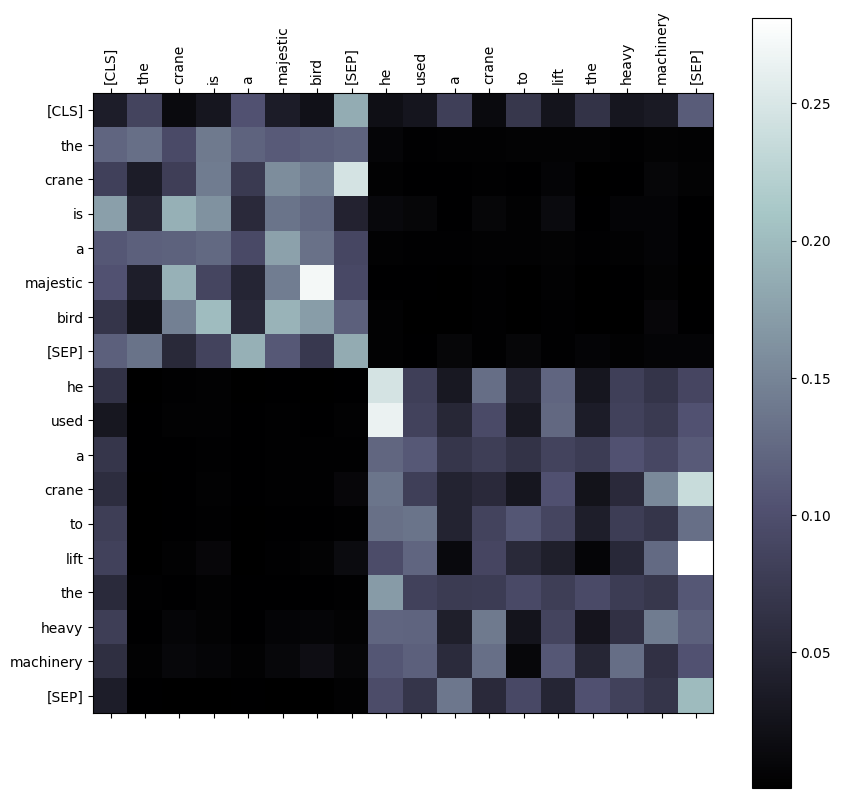

In [ ]:
# Visualizing the attention weights
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(attention, cmap='bone')
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + tokens, rotation=90)
ax.set_yticklabels([''] + tokens)

# Show labels at every tick
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

plt.show()

Another interation of the attention weight exercise, this one shows sentence 1 on the y-axis and sentence 2 on the x-axis

<ipython-input-45-273d7acf4846>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + tokens2, rotation=90)
<ipython-input-45-273d7acf4846>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + tokens1)


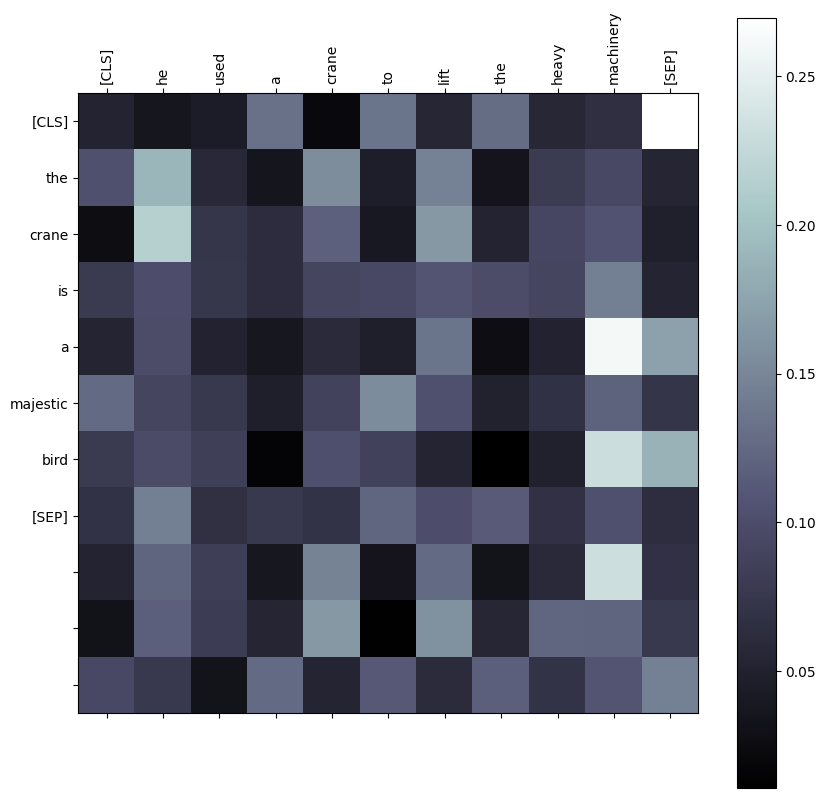

In [ ]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#model2 = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

# Encode text
text1 = "The crane is a majestic bird"
text2 = "He used a crane to lift the heavy machinery"

inputs1 = tokenizer(text1, return_tensors="pt")
inputs2 = tokenizer(text2, return_tensors="pt")

# Get model output
with torch.no_grad():
    outputs1 = model2(**inputs1)
    outputs2 = model2(**inputs2)

# Extract attentions
attentions1 = outputs1.attentions  # Tuple of 12 (one per layer) matrices of shape (batch_size, num_heads, sequence_length, sequence_length)
attentions2 = outputs2.attentions

# For simplicity, we'll use the attention weights from the first layer and the first head.
attention1 = attentions1[0][0, 0, :, :].detach().numpy()
attention2 = attentions2[0][0, 0, :, :].detach().numpy()

# Tokenize the text to match tokens with attention weights
tokens1 = tokenizer.tokenize(tokenizer.decode(inputs1['input_ids'][0]))
tokens2 = tokenizer.tokenize(tokenizer.decode(inputs2['input_ids'][0]))

# Visualizing the attention weights
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(attention2, cmap='bone')
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + tokens2, rotation=90)
ax.set_yticklabels([''] + tokens1)

# Show labels at every tick
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

plt.show()